# GraphML Session 03


## OSM Analysis

Here we'll add weights to our graph based on nearby amenities as described in Open Street Maps.

In [39]:
!pip install osmnx

In [40]:
import networkx as nx
import osmnx as ox
import pandas as pd
import numpy as np
from collections import Counter
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

 Divide the City into Grid Cells

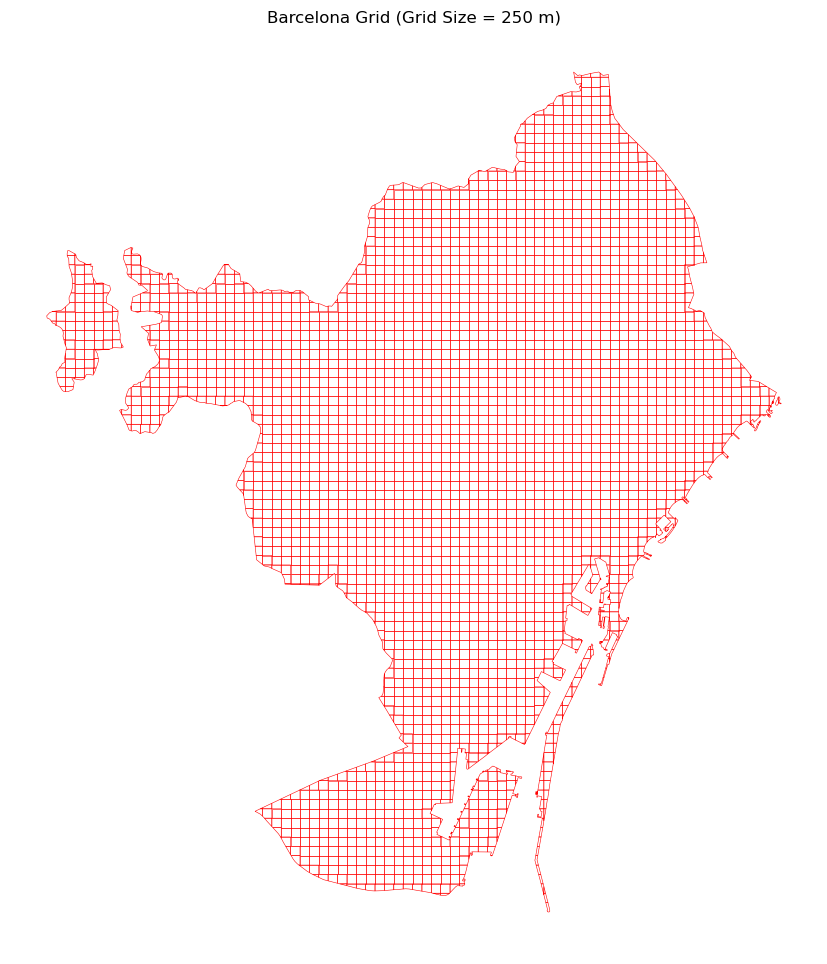

In [41]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
import numpy as np

# Get city boundary
barcelona = ox.geocode_to_gdf("Barcelona, Spain").to_crs(epsg=3857)

# Grid size in meters – change this value to test
grid_size = 250  # Try 150, 200, etc.

# Generate grid
minx, miny, maxx, maxy = barcelona.total_bounds
cells = []
for x in np.arange(minx, maxx, grid_size):
    for y in np.arange(miny, maxy, grid_size):
        cells.append(box(x, y, x + grid_size, y + grid_size))
grid = gpd.GeoDataFrame(geometry=cells, crs=barcelona.crs)
grid = gpd.overlay(grid, barcelona, how="intersection")
grid["cell_id"] = range(len(grid))
# Plot the grid only
fig, ax = plt.subplots(figsize=(12, 12))
grid.plot(ax=ax, edgecolor="red", facecolor="none", linewidth=0.4)
plt.title(f"Barcelona Grid (Grid Size = {grid_size} m)")
plt.axis("off")
plt.show()


Tilted grid to match Eixample

C:\Users\DELL\AppData\Local\Temp\ipykernel_37036\3216475066.py:18: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  cx, cy = barcelona.geometry.unary_union.centroid.coords[0]


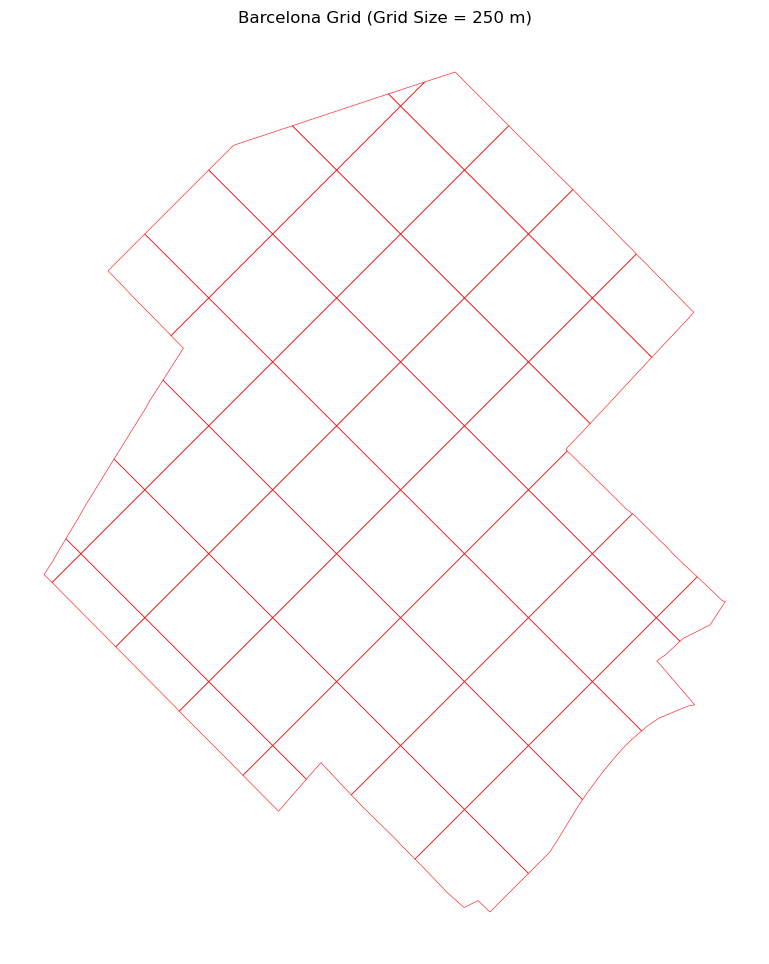

In [42]:
from shapely import affinity

# 1. Define the rotation angle (in degrees)
rotation_angle = -45  # Eixample tilt is ~30° clockwise → -30 to rotate clockwise
# Get city boundary
barcelona = ox.geocode_to_gdf("Poblenou, Barcelona, Spain").to_crs(epsg=3857)
# 2. Generate the grid
grid_size = 250  # Use Eixample-like block size
minx, miny, maxx, maxy = barcelona.total_bounds
cells = []

for x in np.arange(minx, maxx, grid_size):
    for y in np.arange(miny, maxy, grid_size):
        cell = box(x, y, x + grid_size, y + grid_size)
        cells.append(cell)

# 3. Apply rotation around the center of the city
cx, cy = barcelona.geometry.unary_union.centroid.coords[0]
rotated_cells = [affinity.rotate(cell, rotation_angle, origin=(cx, cy)) for cell in cells]

# 4. Create GeoDataFrame and clip
grid = gpd.GeoDataFrame(geometry=rotated_cells, crs=barcelona.crs)
grid = gpd.overlay(grid, barcelona, how="intersection")
grid["cell_id"] = range(len(grid))
# Plot the grid only
fig, ax = plt.subplots(figsize=(12, 12))
grid.plot(ax=ax, edgecolor="red", facecolor="none", linewidth=0.4)
plt.title(f"Barcelona Grid (Grid Size = {grid_size} m)")
plt.axis("off")
plt.show()


Download Streets + Buildings for Background

In [43]:
# Download streets and building footprints
G = ox.graph_from_place("Poblenou, Barcelona, Spain", network_type="drive")
streets = ox.graph_to_gdfs(G, nodes=False, edges=True).to_crs(epsg=3857)
buildings = ox.features_from_place("Poblenou,Barcelona, Spain", tags={"building": True})



 Plot Everything Together

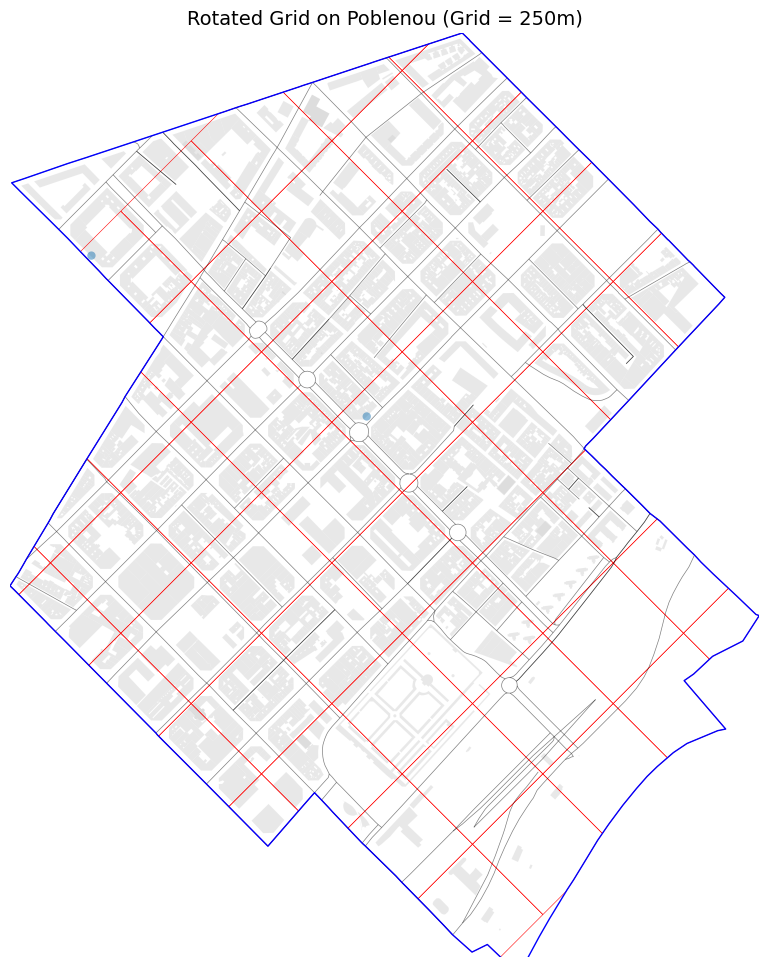

In [44]:
# Reproject buildings to match grid
buildings = buildings.to_crs(epsg=3857)
# Plot everything
fig, ax = plt.subplots(figsize=(12, 12))
streets.plot(ax=ax, linewidth=0.5, color="black", alpha=0.5)
buildings.plot(ax=ax, facecolor="lightgray", edgecolor="none", alpha=0.5)
grid.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=0.4)
barcelona.boundary.plot(ax=ax, edgecolor="blue", linewidth=1)

# Zoom into the actual grid area
ax.set_xlim(grid.total_bounds[0], grid.total_bounds[2])
ax.set_ylim(grid.total_bounds[1], grid.total_bounds[3])
ax.set_aspect("equal")

plt.title(f"Rotated Grid on Poblenou (Grid = {grid_size}m)", fontsize=14)
plt.axis("off")
plt.show()

##GridGenerator Class

In [ ]:
import osmnx as ox
import geopandas as gpd
from shapely.geometry import box
from shapely import affinity
import numpy as np

class RotatedGridGenerator:
    def __init__(self, place_name, grid_size=113, rotation_angle=-45):
        """
        place_name: str - the name of the location (e.g. "Poblenou, Barcelona, Spain")
        grid_size: int - the grid cell size in meters (width = height)
        rotation_angle: float - clockwise rotation in degrees (e.g., -45)
        """
        self.place_name = place_name
        self.grid_size = grid_size
        self.rotation_angle = rotation_angle
        self.city_boundary = self._get_boundary()
        self.crs = self.city_boundary.crs
        self.grid = self._generate_rotated_grid()

    def _get_boundary(self):
        """Download and return the city or neighborhood boundary"""
        return ox.geocode_to_gdf(self.place_name).to_crs(epsg=3857)

    def _generate_rotated_grid(self):
        """Create a rotated square grid clipped to the city boundary"""
        minx, miny, maxx, maxy = self.city_boundary.total_bounds
        cells = []
        for x in np.arange(minx, maxx, self.grid_size):
            for y in np.arange(miny, maxy, self.grid_size):
                cell = box(x, y, x + self.grid_size, y + self.grid_size)
                cells.append(cell)

        # Rotate grid around city center
        cx, cy = self.city_boundary.geometry.unary_union.centroid.coords[0]
        rotated_cells = [affinity.rotate(cell, self.rotation_angle, origin=(cx, cy)) for cell in cells]

        grid = gpd.GeoDataFrame(geometry=rotated_cells, crs=self.crs)
        grid = gpd.overlay(grid, self.city_boundary, how="intersection")
        grid["cell_id"] = range(len(grid))
        return grid

    def get_grid(self):
        """Return the rotated clipped grid as a GeoDataFrame"""
        return self.grid
    @staticmethod
    def generate_rotated_unclipped_grid(place_name, cell_size=250, rotation_angle=-45):
        """
        Generates full square cells (rotated), filtered by intersection with boundary (not clipped).
        """
        # Get boundary
        boundary = ox.geocode_to_gdf(place_name).to_crs(epsg=3857)
        bounds = boundary.total_bounds
        xmin, ymin, xmax, ymax = bounds

        # Generate square cells
        cells = []
        for x in np.arange(xmin, xmax, cell_size):
            for y in np.arange(miny, ymax, cell_size):
                cell = box(x, y, x + cell_size, y + cell_size)
                cells.append(cell)

        # Rotate all grid cells
        cx, cy = boundary.geometry.unary_union.centroid.coords[0]
        rotated_cells = [affinity.rotate(cell, rotation_angle, origin=(cx, cy)) for cell in cells]

        grid = gpd.GeoDataFrame(geometry=rotated_cells, crs=boundary.crs)

        # 🟨 Filter only intersecting (but keep full cells)
        # Ensure boundary is clean and unary-unioned
        boundary_geom = boundary.geometry.unary_union.buffer(0)  # Fix invalid geometry if any

# Keep only full grid cells that intersect the boundary polygon
        grid["keep"] = grid.geometry.apply(lambda g: g.intersects(boundary_geom))
        grid = grid[grid["keep"]].drop(columns="keep").reset_index(drop=True)

        grid["cell_id"] = range(len(grid))
        grid["keep"] = grid.geometry.apply(lambda g: g.buffer(0.5).intersects(boundary_geom))

        return grid, boundary

    def plot(self, ax=None, **kwargs):
        """Quick visualization of the grid"""
        if ax is None:
            import matplotlib.pyplot as plt
            fig, ax = plt.subplots(figsize=(10, 10))
        self.city_boundary.boundary.plot(ax=ax, edgecolor="blue")
        self.grid.plot(ax=ax, edgecolor="red", facecolor="none", **kwargs)
        ax.set_title(f"Rotated Grid on {self.place_name} (size={self.grid_size}m, angle={self.rotation_angle}°)")
        ax.set_axis_off()
        ax.set_aspect("equal")
        return ax


In [46]:
grid, boundary = RotatedGridGenerator.generate_rotated_unclipped_grid("Poblenou, Barcelona, Spain", cell_size=250, rotation_angle=-45)


C:\Users\DELL\AppData\Local\Temp\ipykernel_37036\3706962056.py:64: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  cx, cy = boundary.geometry.unary_union.centroid.coords[0]
C:\Users\DELL\AppData\Local\Temp\ipykernel_37036\3706962056.py:71: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  boundary_geom = boundary.geometry.unary_union.buffer(0)  # Fix invalid geometry if any


C:\Users\DELL\AppData\Local\Temp\ipykernel_37036\3706962056.py:35: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  cx, cy = self.city_boundary.geometry.unary_union.centroid.coords[0]


<Axes: title={'center': 'Rotated Grid on Poblenou, Barcelona, Spain (size=226m, angle=-45°)'}>

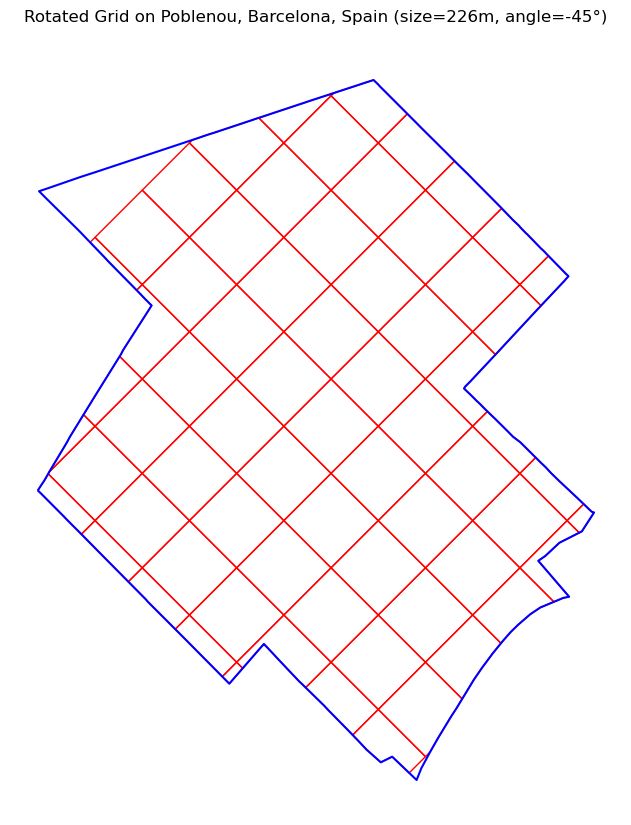

In [47]:
# Create a grid over Poblenou, with 2x2 blocks per cell (~226m), rotated 45°
gridgen = RotatedGridGenerator("Poblenou, Barcelona, Spain", grid_size=226, rotation_angle=-45)

# Get the grid as GeoDataFrame
grid = gridgen.get_grid()

# Plot it
gridgen.plot()


For Expanding Boundary

In [166]:
import osmnx as ox
import geopandas as gpd
import numpy as np
from shapely.geometry import box
from shapely import affinity

class RotatedGridGenerator:
    def __init__(self, place_name=None, grid_size=250, rotation_angle=-45, custom_boundary=None):
        """
        place_name: str – OSM place name (optional if using custom_boundary)
        grid_size: int – size of each grid cell in meters
        rotation_angle: float – rotation angle in degrees (clockwise)
        custom_boundary: GeoDataFrame – optional custom polygon (must be in EPSG:3857)
        """
        self.place_name = place_name
        self.grid_size = grid_size
        self.rotation_angle = rotation_angle

        # Determine boundary
        if custom_boundary is not None:
            self.city_boundary = custom_boundary
        elif place_name is not None:
            self.city_boundary = ox.geocode_to_gdf(place_name).to_crs(epsg=3857)
        else:
            raise ValueError("Either place_name or custom_boundary must be provided.")

        self.crs = self.city_boundary.crs

    @staticmethod
    def generate_rotated_unclipped_grid(place_name=None, custom_boundary=None, cell_size=250, rotation_angle=-45):
        """
        Generates full square cells (rotated), filtered by intersection with boundary (not clipped).
        Accepts either a place_name or a custom_boundary GeoDataFrame.
        """
        if custom_boundary is not None:
            boundary = custom_boundary
        elif place_name is not None:
            boundary = ox.geocode_to_gdf(place_name).to_crs(epsg=3857)
        else:
            raise ValueError("You must provide either a place_name or a custom_boundary.")

        bounds = boundary.total_bounds
        xmin, ymin, xmax, ymax = bounds

        # Generate square cells
        cells = []
        for x in np.arange(xmin, xmax, cell_size):
            for y in np.arange(ymin, ymax, cell_size):
                cell = box(x, y, x + cell_size, y + cell_size)
                cells.append(cell)

        # Rotate all grid cells
        cx, cy = boundary.geometry.unary_union.centroid.coords[0]
        rotated_cells = [affinity.rotate(cell, rotation_angle, origin=(cx, cy)) for cell in cells]

        grid = gpd.GeoDataFrame(geometry=rotated_cells, crs=boundary.crs)

        # Filter only intersecting (keep full cells)
        boundary_geom = boundary.geometry.unary_union.buffer(0)  # fix invalid geometry
        grid["keep"] = grid.geometry.apply(lambda g: g.intersects(boundary_geom))
        grid = grid[grid["keep"]].drop(columns="keep").reset_index(drop=True)

        grid["cell_id"] = range(len(grid))
        return grid, boundary

    def plot(self, ax=None, **kwargs):
        """Quick visualization of the grid"""
        if ax is None:
            import matplotlib.pyplot as plt
            fig, ax = plt.subplots(figsize=(10, 10))
        self.city_boundary.boundary.plot(ax=ax, edgecolor="blue")
        self.grid.plot(ax=ax, edgecolor="red", facecolor="none", **kwargs)
        ax.set_title(f"Rotated Grid on {self.place_name or 'Custom Area'} (size={self.grid_size}m, angle={self.rotation_angle}°)")
        ax.set_axis_off()
        ax.set_aspect("equal")
        return ax


In [167]:
# 1. Buffer the original Poblenou boundary
place_name = "Poblenou, Barcelona, Spain"
base_boundary = ox.geocode_to_gdf(place_name).to_crs(epsg=3857)
expanded_boundary = gpd.GeoDataFrame(geometry=base_boundary.buffer(1000), crs=base_boundary.crs)

# 2. Generate grid using the updated staticmethod
grid, boundary = RotatedGridGenerator.generate_rotated_unclipped_grid(
    custom_boundary=expanded_boundary, 
    cell_size=250, 
    rotation_angle=-45
)


C:\Users\DELL\AppData\Local\Temp\ipykernel_37036\4196430486.py:53: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  cx, cy = boundary.geometry.unary_union.centroid.coords[0]
C:\Users\DELL\AppData\Local\Temp\ipykernel_37036\4196430486.py:59: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  boundary_geom = boundary.geometry.unary_union.buffer(0)  # fix invalid geometry


<bound method _AxesBase.axis of <Axes: title={'center': 'Rotated Grid on Expanded Poblenou'}>>

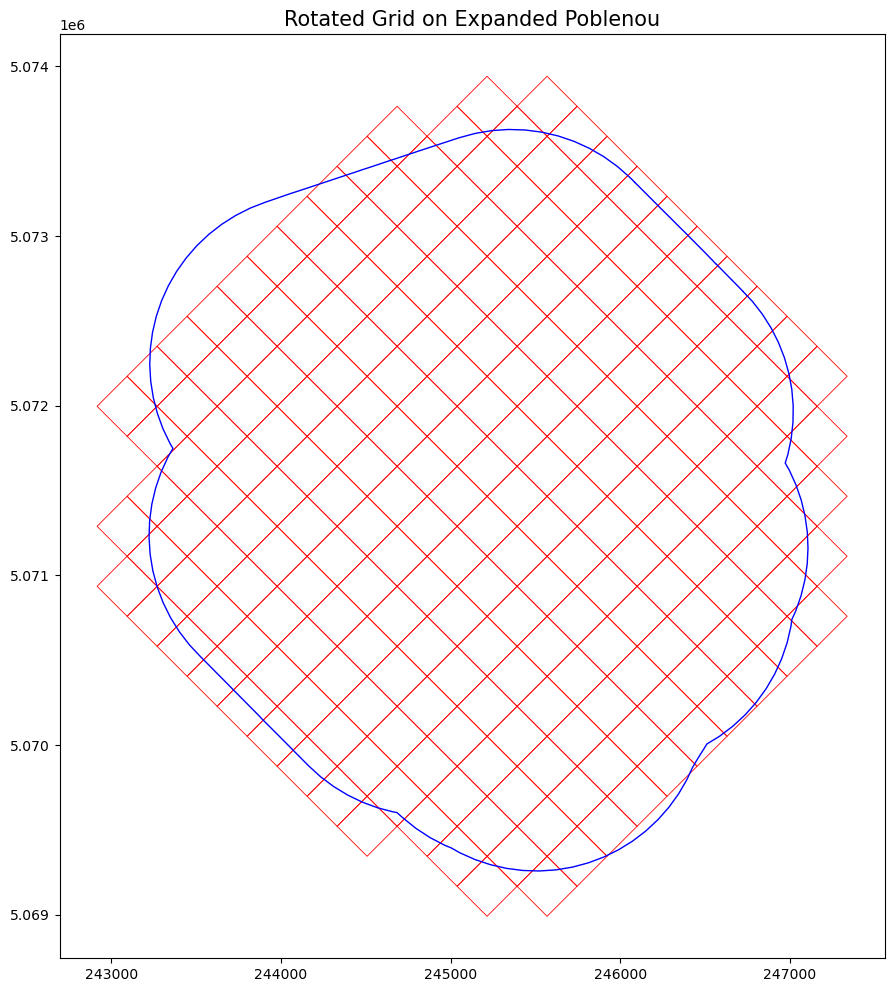

In [168]:
import matplotlib.pyplot as plt

# grid and boundary already returned by the static method
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the expanded boundary (transparent fill)
boundary.boundary.plot(ax=ax, edgecolor='blue', linewidth=1)

# Plot the rotated grid cells
grid.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=0.6)

# Titles and formatting
ax.set_title("Rotated Grid on Expanded Poblenou", fontsize=15)
ax.set_aspect("equal")
ax.axis


##AMENITIES

We start by gettin a location:

In [48]:
place_name = "Poblenou, Barcelona, Spain"
G = ox.graph_from_place(place_name, network_type="drive")


Next, we define what kind of "amenities" do we want to extract from OSM.

Key values to look for refer to https://wiki.openstreetmap.org/wiki/Map_Features


In [49]:
# set value to True for all values pairable to the key
key = "amenity"
value = ["bar","restaurant","pub","cafe","fast_food"]

# Download the Points of interest
tags = {key: value}
gdf = ox.features_from_place(place_name, tags=tags)
gdf

geometry  \
element id                                                              
node    660100527                            POINT (2.19677 41.40469)   
        660100529                            POINT (2.19419 41.40486)   
        660771772                             POINT (2.19776 41.4035)   
        660778771                             POINT (2.19865 41.4029)   
        660784487                             POINT (2.1989 41.40273)   
...                                                               ...   
way     217583616   POLYGON ((2.2063 41.39474, 2.20638 41.39468, 2...   
        412702054   POLYGON ((2.20418 41.39528, 2.2042 41.39527, 2...   
        1367091257  POLYGON ((2.2056 41.39331, 2.20564 41.39337, 2...   
        1367091871  POLYGON ((2.20644 41.39433, 2.2065 41.39439, 2...   
        1367092595  POLYGON ((2.20785 41.39543, 2.20789 41.39546, ...   

                       amenity  cuisine                             name  \
element id                                                                 
node    660100527         cafe  spanish                  Rambla Poblenou   
        660100529         cafe      NaN                        El Fornet   
        660771772    fast_food  chicken                           Apluma   
        660778771   restaurant  spanish                   braseria xorus   
        660784487   restaurant      NaN                      La broqueta   
...                        ...      ...                              ...   
way     217583616   restaurant  seafood                       Can Fisher   
        412702054         cafe      NaN                          Camping   
        1367091257        cafe      NaN                          Bo Kaap   
        1367091871        cafe      NaN                        Vai Moana   
        1367092595        cafe      NaN  Barcelona beach. El Chiringuito   

                        shop indoor_seating outdoor_seating  \
element id                                                    
node    660100527   optician            NaN             NaN   
        660100529        NaN            yes             yes   
        660771772        NaN            NaN             NaN   
        660778771        NaN            yes             yes   
        660784487        NaN            NaN             NaN   
...                      ...            ...             ...   
way     217583616        NaN            NaN             yes   
        412702054        NaN            NaN             NaN   
        1367091257       NaN            NaN             NaN   
        1367091871       NaN            NaN             NaN   
        1367092595       NaN            NaN             NaN   

                                     website addr:housenumber addr:postcode  \
element id                                                                    
node    660100527                        NaN              NaN           NaN   
        660100529   https://elfornet.com/es/              NaN           NaN   
        660771772    https://www.apluma.com/              117         08018   
        660778771                        NaN              105           NaN   
        660784487                        NaN              NaN           NaN   
...                                      ...              ...           ...   
way     217583616                        NaN              NaN           NaN   
        412702054                        NaN              NaN           NaN   
        1367091257                       NaN              NaN           NaN   
        1367091871                       NaN              NaN           NaN   
        1367092595                       NaN              NaN           NaN   

                    ... image payment:cards name:ro building contact:city  \
element id          ...                                                     
node    660100527   ...   NaN           NaN     NaN      NaN          NaN   
        660100529   ...   NaN           NaN

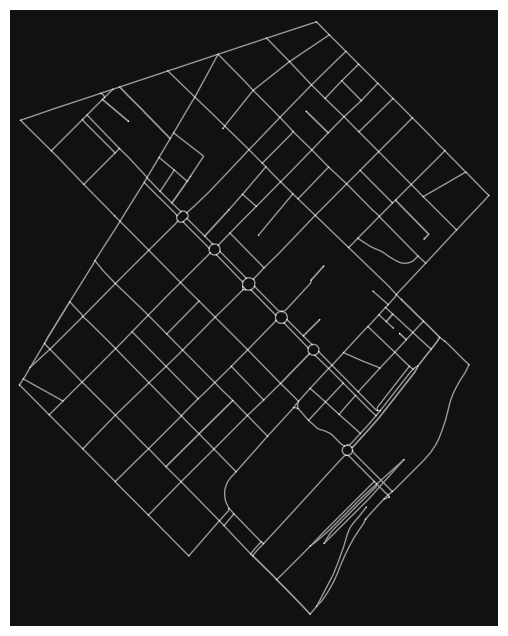

(237, 76)

In [50]:
ox.plot_graph(G, node_size=1)
gdf.shape

In [51]:
# Filter out non-points geometry
gdf_pts = gdf.loc[gdf.geometry.geometry.type=='Point']
gdf_pts.shape
gdf_pts

geometry     amenity  \
element id                                                  
node    660100527    POINT (2.19677 41.40469)        cafe   
        660100529    POINT (2.19419 41.40486)        cafe   
        660771772     POINT (2.19776 41.4035)   fast_food   
        660778771     POINT (2.19865 41.4029)  restaurant   
        660784487     POINT (2.1989 41.40273)  restaurant   
...                                       ...         ...   
        12546429118  POINT (2.19897 41.39577)  restaurant   
        12628316609  POINT (2.20449 41.39877)        cafe   
        12691417681   POINT (2.19818 41.4043)        cafe   
        12837309875  POINT (2.19937 41.40049)        cafe   
        12878647527  POINT (2.19749 41.39907)        cafe   

                                          cuisine             name      shop  \
element id                                                                     
node    660100527                         spanish  Rambla Poblenou  optician   
        660100529                             NaN        El Fornet       NaN   
        660771772                         chicken           Apluma       NaN   
        660778771                         spanish   braseria xorus       NaN   
        660784487                             NaN      La broqueta       NaN   
...                                           ...              ...       ...   
        12546429118                           NaN             Miny       NaN   
        12628316609                           NaN    Repúblic Cafè       NaN   
        12691417681  coffee_shop;breakfast;brunch         Osom Nou       NaN   
        12837309875                           NaN           Labath       NaN   
        12878647527                           NaN        Mono Cafe       NaN   

                    indoor_seating outdoor_seating                   website  \
element id                                                                     
node    660100527              NaN             NaN                       NaN   
        660100529              yes             yes  https://elfornet.com/es/   
        660771772              NaN             NaN   https://www.apluma.com/   
        660778771              yes             yes                       NaN   
        660784487              NaN             NaN                       NaN   
...                            ...             ...                       ...   
        12546429118            NaN             NaN                       NaN   
        12628316609            NaN             NaN                       NaN   
        12691417681            NaN             NaN    https://somososom.com/   
        12837309875            NaN             NaN                       NaN   
        12878647527            yes              no                       NaN   

                    addr:housenumber addr:postcode  ... image payment:cards  \
element id                                          ...                       
node    660100527                NaN           NaN  ...   NaN           NaN   
        660100529                NaN           NaN  ...   NaN           NaN   
        660771772                117         08018  ...   NaN           NaN   
        660778771                105           NaN  ...   NaN           NaN   
        660784487                NaN           NaN  ...   NaN           NaN   
...                              ...           ...  ...   ...           ...   
        12546429118              NaN           NaN  ...   NaN           NaN   
        12628316609               22           NaN  ...   NaN           NaN   
        12691417681              148         08018  ...   NaN           NaN   
        12837309875              NaN           NaN  ...   NaN           NaN   
        12878647527              NaN           NaN  ...   NaN           NaN   

                    name:ro building contact:city contact:housenumber  \
element id                                                  

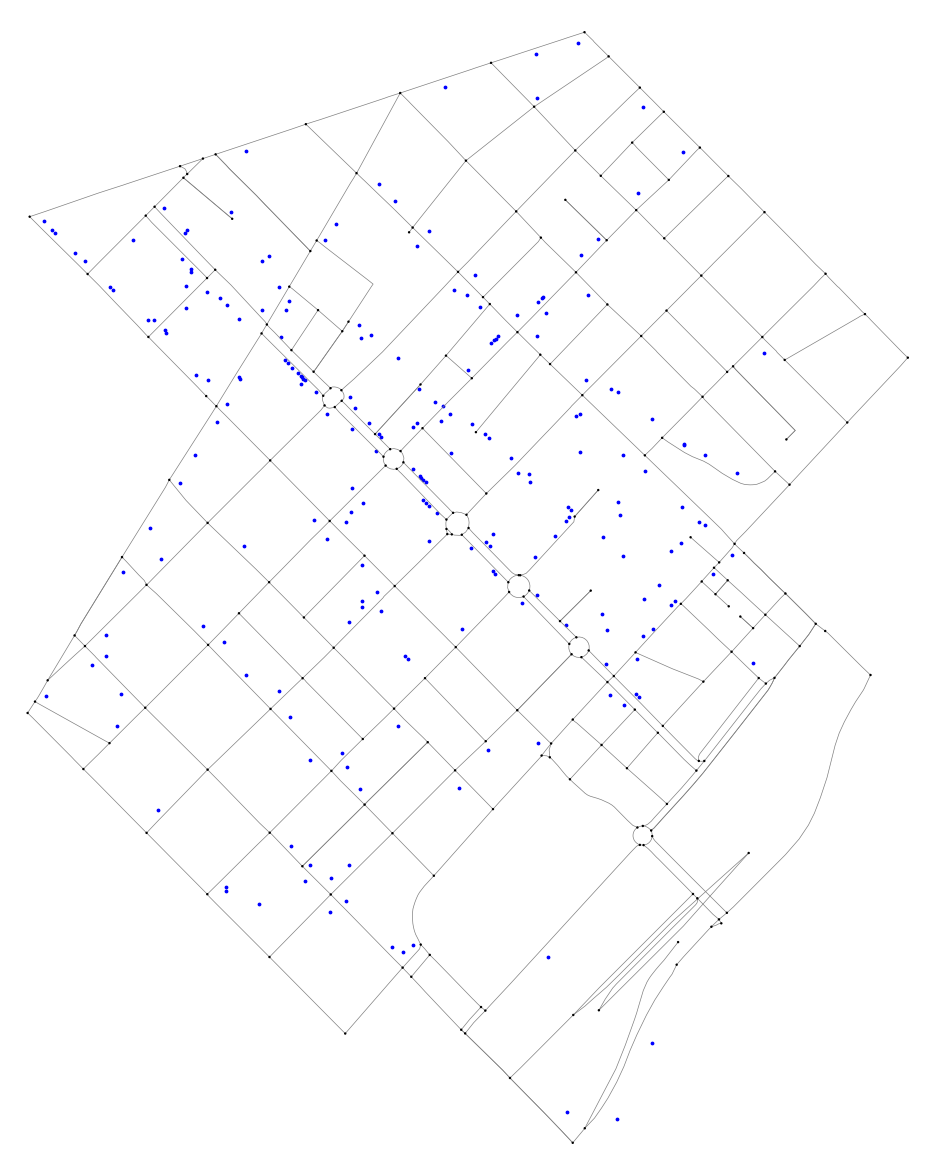

In [52]:
# Start plotting
fig, ax = plt.subplots(figsize=(15, 15))

# Plot GeoDataFrame
gdf_pts.plot(ax=ax, color='blue', markersize=3)

# Draw the graph
ox.plot_graph(G, ax=ax, node_size=3, node_color= "black", edge_linewidth=0.5, edge_color='gray')

plt.show()

In [53]:
import osmnx as ox
import geopandas as gpd
import pandas as pd

place_name = "Poblenou, Barcelona, Spain"

# Download area polygon
place_boundary = ox.geocode_to_gdf(place_name)

# Download all features in the area with broader tags
all_features = ox.features.features_from_polygon(
    place_boundary.geometry.iloc[0],
    tags={"landuse": True, "building": True}
)

# Filter for industrial landuse and warehouse buildings
landuse_industrial = all_features[
    (all_features.get("landuse") == "industrial")
]
building_warehouse = all_features[
    (all_features.get("building") == "warehouse")
]

# Combine into one
smoke_list = pd.concat([landuse_industrial, building_warehouse]).drop_duplicates(subset=["geometry"])
smoke_list.reset_index(drop=True, inplace=True)



In [54]:
nomnom_points = nomnom_list[nomnom_list.geometry.type == "Point"].to_crs(grid.crs)
couch_points = couch_list[couch_list.geometry.type == "Point"].to_crs(grid.crs)
HustleHub_points = HustleHub_list[HustleHub_list.geometry.type == "Point"].to_crs(grid.crs)
smoke_points = smoke_list[smoke_list.geometry.type == "Point"].to_crs(grid.crs)


NameError: name 'nomnom_list' is not defined


CouchCounty raw data downloaded with 370 features.

NomNom raw data downloaded with 237 features.

HustleHub raw data downloaded with 101 features.
CouchCounty simplified to centroids (370 points).
NomNom simplified to centroids (237 points).
HustleHub simplified to centroids (101 points).


C:\Users\DELL\AppData\Local\Temp\ipykernel_37036\1912652829.py:37: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["geometry"] = gdf.geometry.centroid
C:\Users\DELL\AppData\Local\Temp\ipykernel_37036\1912652829.py:37: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["geometry"] = gdf.geometry.centroid
C:\Users\DELL\AppData\Local\Temp\ipykernel_37036\1912652829.py:37: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["geometry"] = gdf.geometry.centroid


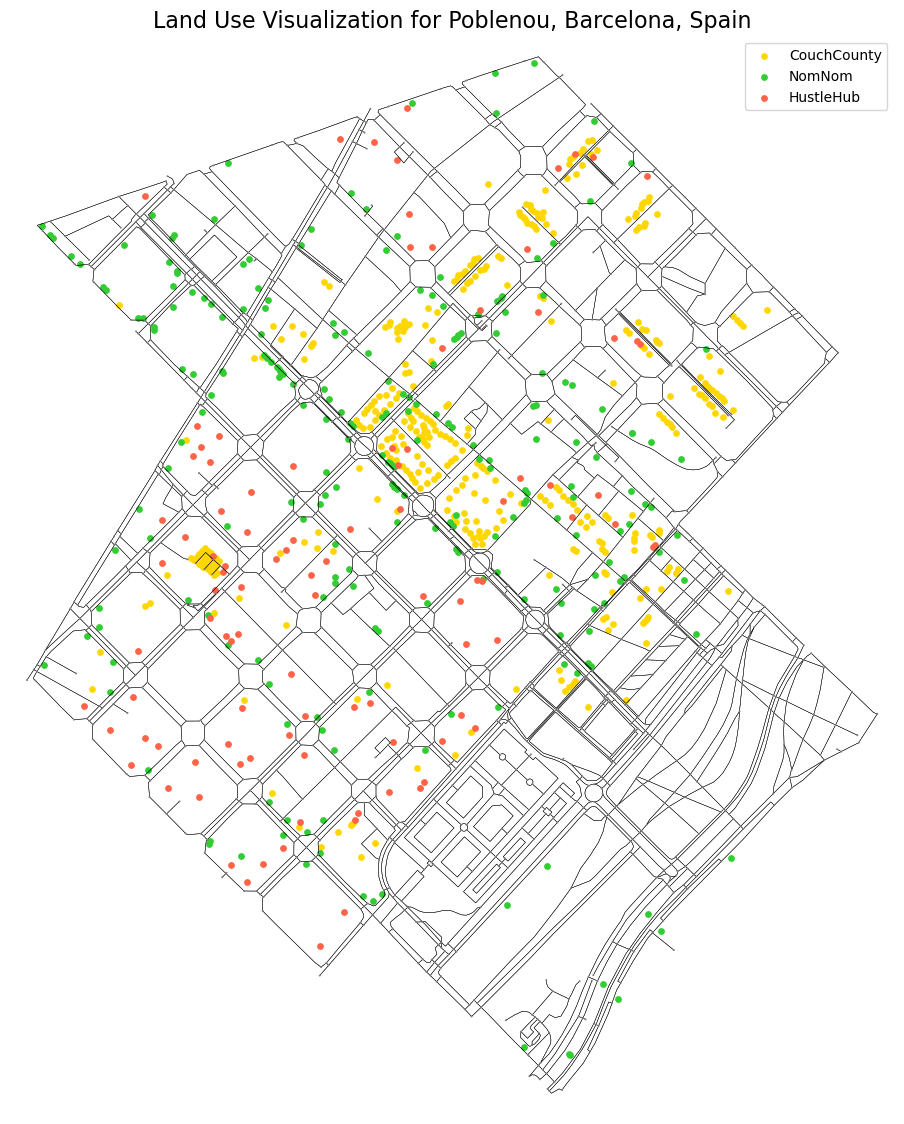

In [55]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt

class OSMLandUseVisualizer:
    def __init__(self, place_name, graph):  # ← FIXED HERE
        self.place_name = place_name
        self.G = graph

        self.tags = {
            "CouchCounty": {
                "building": [
                    "house", "residential", "detached", "dormitory",
                    "bungalow", "semidetached_house", "stilt_house", "terrace"
                ]
            },
            "NomNom": {
                "amenity": ["bar", "restaurant", "pub", "cafe", "fast_food"]
            },
            "HustleHub": {
                "building": ["retail", "commercial", "office", "supermarket", "kiosk"]
            }
        }

        self.dataframes = {}

    def download_data(self):
        for label, tag in self.tags.items():
            gdf = ox.features.features_from_place(self.place_name, tags=tag)
            print(f"\n{label} raw data downloaded with {len(gdf)} features.")
            self.dataframes[label] = gdf

    def simplify_geometry(self):
        for label, gdf in self.dataframes.items():
            gdf = gdf.copy()
            gdf = gdf[gdf.geometry.notnull()]
            gdf["geometry"] = gdf.geometry.centroid
            self.dataframes[label] = gdf
            print(f"{label} simplified to centroids ({len(gdf)} points).")

    def plot(self):
        fig, ax = plt.subplots(figsize=(14, 14))

        color_map = {
            "CouchCounty": 'gold',
            "NomNom": 'limegreen',
            "HustleHub": 'tomato'
        }

        for label, gdf in self.dataframes.items():
            gdf.plot(ax=ax, color=color_map[label], markersize=15, label=label)

        ox.plot_graph(self.G, ax=ax, node_size=2, node_color="gray", edge_linewidth=0.3, edge_color='black', show=False, close=False)

        plt.legend()
        plt.title(f"Land Use Visualization for {self.place_name}", fontsize=16)
        plt.axis("off")
        plt.show()
place_name = "Poblenou, Barcelona, Spain"
G = ox.graph_from_place(place_name, network_type='walk')

visualizer = OSMLandUseVisualizer(place_name, G)
visualizer.download_data()
visualizer.simplify_geometry()
visualizer.plot()


##spatiotemporal dataset (metadata for each cell)

In [56]:
grid["cell_id"] = range(len(grid))


In [57]:
buildings = buildings[buildings.geometry.type.isin(['Polygon', 'MultiPolygon'])]


In [58]:
#Relate data to each grid cell
# Spatial join POIs to grid

gdf_pts_proj = gdf_pts.to_crs(grid.crs)

poi_in_cells = gpd.sjoin(gdf_pts_proj, grid, how="inner", predicate="within")
poi_counts = poi_in_cells.groupby("cell_id").size().rename("num_amenities")

# Spatial join streets to grid
streets_in_cells = gpd.overlay(streets, grid, how="intersection")
street_length = streets_in_cells.length.groupby(streets_in_cells["cell_id"]).sum().rename("street_length")

# Spatial join buildings to grid
buildings_in_cells = gpd.overlay(buildings, grid, how="intersection")
building_count = buildings_in_cells.groupby("cell_id").size().rename("num_buildings")


c:\Users\DELL\anaconda3\envs\barcelona_env\Lib\site-packages\geopandas\tools\overlay.py:357: UserWarning: `keep_geom_type=True` in overlay resulted in 6 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


In [59]:
#Merge these into the grid as metadata
grid = grid.set_index("cell_id")
grid = grid.join([poi_counts, street_length, building_count])
grid = grid.fillna(0).reset_index()


In [60]:
#Add a timestamp
grid["year"] = 2023


##CityGridMetadataBuilder & Categorization of Cells

Example Usage

In [61]:
metadata_grid = builder.get_grid_with_metadata()

# View metadata for cell_id = 42
cell_metadata = metadata_grid[metadata_grid["cell_id"] == 36]
print(cell_metadata)


NameError: name 'builder' is not defined

NameError: name 'metadata_grid' is not defined

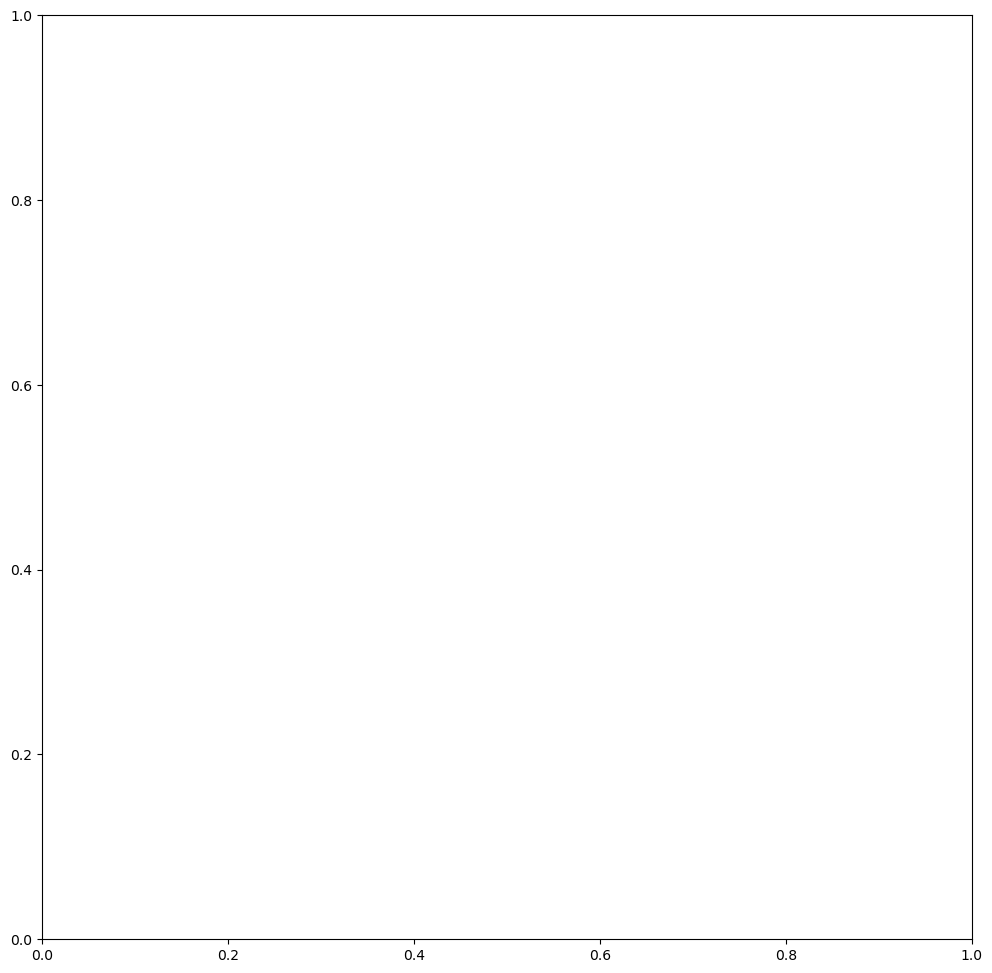

In [62]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 12))

# 1. Plot the grid cells
metadata_grid.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5)

# 2. Add `cell_id` as a label at each grid cell's centroid
for idx, row in metadata_grid.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, str(row.cell_id), 
            ha='center', va='center', fontsize=8, color='red')

# 3. Optional title and remove axis
ax.set_title("Grid Cells with cell_id Labels")
ax.axis('off')
plt.show()




Class for categorization

In [63]:
import geopandas as gpd
import pandas as pd

class CityGridMetadataBuilder:
    def __init__(self, grid: gpd.GeoDataFrame, year: int):
        self.grid = grid.copy()
        self.grid["cell_id"] = range(len(grid))
        self.grid["year"] = year
        self.grid = self.grid.set_geometry("geometry")
        self.grid = self.grid.to_crs(epsg=3857)  # Match CRS used in POIs

    def prepare_pois(self, poi_gdfs: dict):
        for label, gdf in poi_gdfs.items():
            gdf = gdf[gdf.geometry.notnull()].copy()
            gdf = gdf.to_crs(self.grid.crs)
            gdf["geometry"] = gdf.geometry.centroid
            poi_gdfs[label] = gdf

    def classify_dominant_zone(self, poi_gdfs: dict, category_info: dict):
        for label in category_info:
            gdf = poi_gdfs[label]
            joined = gpd.sjoin(gdf, self.grid, how="left", predicate="within")
            counts = joined.groupby("index_right").size().rename(f"{label}_count")
            self.grid[f"{label}_count"] = self.grid.index.map(counts).fillna(0)

        def get_dominant(row):
            counts = {label: row.get(f"{label}_count", 0) for label in category_info}
            return max(counts, key=counts.get)

        self.grid["dominant_zone"] = self.grid.apply(get_dominant, axis=1)
        self.grid["zone_label"] = self.grid["dominant_zone"].map(lambda z: category_info[z]["label"])
        self.grid["color"] = self.grid["dominant_zone"].map(lambda z: category_info[z]["color"])

    def add_street_length(self, streets_gdf: gpd.GeoDataFrame):
        streets = streets_gdf.to_crs(self.grid.crs)
        streets["length"] = streets.geometry.length
        joined = gpd.sjoin(streets, self.grid, how="left", predicate="intersects")
        lengths = joined.groupby("index_right")["length"].sum().rename("street_length")
        self.grid["street_length"] = self.grid.index.map(lengths).fillna(0)

    def add_building_count(self, buildings_gdf: gpd.GeoDataFrame):
        buildings = buildings_gdf.to_crs(self.grid.crs)
        joined = gpd.sjoin(buildings, self.grid, how="left", predicate="within")
        counts = joined.groupby("index_right").size().rename("num_buildings")
        self.grid["num_buildings"] = self.grid.index.map(counts).fillna(0)

    def get_grid_with_metadata(self):
        return self.grid.reset_index(drop=True)



In [64]:
tags = {
    "NomNom": {"amenity": ["restaurant", "cafe", "fast_food", "bar"]},
    "CouchCounty": {"building": ["residential", "house", "apartments", "bungalow"]},
    "HustleHub": {"building": ["retail", "commercial", "office", "supermarket"]}
}

CATEGORY_INFO = {
    "NomNom": {"color": "#ff6347", "label": "Food & Beverage"},
    "CouchCounty": {"color": "#f4e842", "label": "Residential"},
    "HustleHub": {"color": "#42f5e9", "label": "Commercial"}
}


In [65]:
import osmnx as ox

place_name = "Poblenou, Barcelona, Spain"
poi_dfs = {}

for label, tag in tags.items():
    gdf = ox.features_from_place(place_name, tags=tag)
    poi_dfs[label] = gdf


In [66]:
# 📍 Download street network (drivable roads)
G = ox.graph_from_place("Poblenou, Barcelona, Spain", network_type="drive")
streets_gdf = ox.graph_to_gdfs(G, nodes=False, edges=True).to_crs(epsg=3857)

# 🏢 Download building footprints
buildings_gdf = ox.features_from_place("Poblenou, Barcelona, Spain", tags={"building": True})
buildings_gdf = buildings_gdf.to_crs(epsg=3857)


In [67]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_dominant_zones(zoned_grid, category_info, boundary=None, title="Dominant Zone per Grid Cell"):
    fig, ax = plt.subplots(figsize=(12, 12))

    if boundary is not None:
        boundary.to_crs(zoned_grid.crs).plot(ax=ax, facecolor="white", edgecolor="black", linewidth=1)

    zoned_grid.plot(ax=ax, facecolor=zoned_grid["color"], edgecolor="gray", linewidth=0.2)

    legend_patches = [
        mpatches.Patch(color=info["color"], label=info["label"])
        for info in category_info.values()
    ]
    ax.legend(handles=legend_patches, loc="upper right", title="Dominant Zone", frameon=True)
    ax.set_title(title, fontsize=15)
    ax.axis("off")
    plt.tight_layout()
    plt.show()


In [68]:
from shapely.geometry import box
from shapely import affinity
import geopandas as gpd
import numpy as np
import osmnx as ox

def generate_rotated_clipped_grid(place_name, cell_size=250, rotation_angle=-45):
    """
    Generates a rotated and accurately clipped grid for a city or neighborhood.

    place_name: str – e.g. "Poblenou, Barcelona, Spain"
    cell_size: int – cell size in meters
    rotation_angle: float – rotation in degrees (clockwise, e.g., -45)
    """
    # Download boundary
    boundary = ox.geocode_to_gdf(place_name).to_crs(epsg=3857)
    bounds = boundary.total_bounds
    xmin, ymin, xmax, ymax = bounds

    # Create square cells
    cells = []
    for x in np.arange(xmin, xmax, cell_size):
        for y in np.arange(miny, ymax, cell_size):
            cells.append(box(x, y, x + cell_size, y + cell_size))

    # Rotate cells around center of the area
    cx, cy = boundary.geometry.unary_union.centroid.coords[0]
    rotated_cells = [affinity.rotate(cell, rotation_angle, origin=(cx, cy)) for cell in cells]

    # Create GeoDataFrame and clip precisely to boundary
    grid = gpd.GeoDataFrame(geometry=rotated_cells, crs=boundary.crs)
    clipped_grid = gpd.overlay(grid, boundary, how="intersection")
    clipped_grid["cell_id"] = range(len(clipped_grid))
    
    return clipped_grid, boundary


C:\Users\DELL\AppData\Local\Temp\ipykernel_37036\3706962056.py:64: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  cx, cy = boundary.geometry.unary_union.centroid.coords[0]
C:\Users\DELL\AppData\Local\Temp\ipykernel_37036\3706962056.py:71: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  boundary_geom = boundary.geometry.unary_union.buffer(0)  # Fix invalid geometry if any


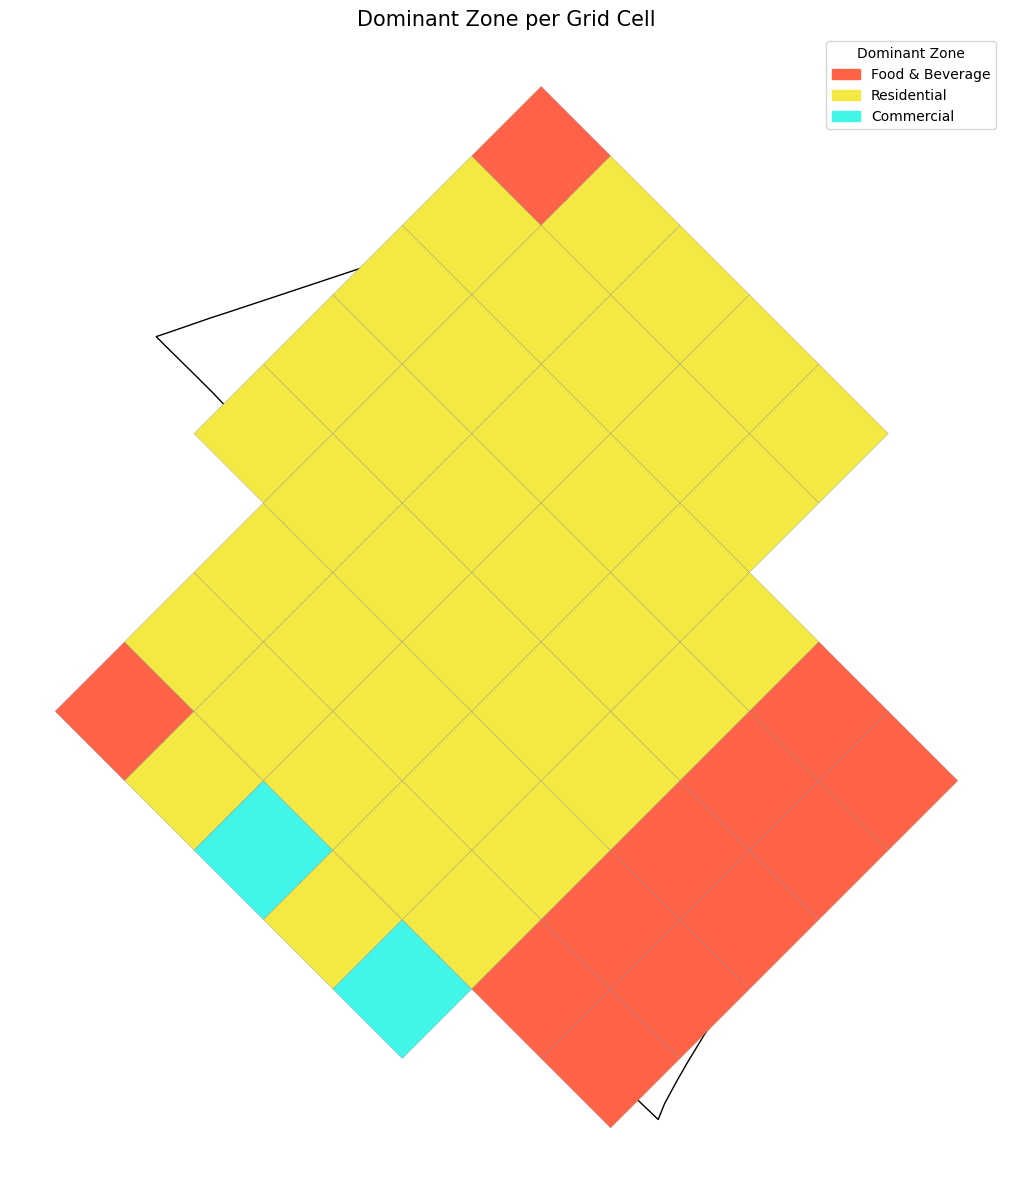

In [69]:
# 1. Generate rotated and clipped grid
grid, boundary = RotatedGridGenerator.generate_rotated_unclipped_grid("Poblenou, Barcelona, Spain", cell_size=250, rotation_angle=-45)

# 2. Proceed as before
builder = CityGridMetadataBuilder(grid, year=2025)
builder.prepare_pois(poi_dfs)
builder.classify_dominant_zone(poi_dfs, CATEGORY_INFO)
builder.add_street_length(streets_gdf)
builder.add_building_count(buildings_gdf)
zoned_grid = builder.get_grid_with_metadata()

# 3. Visualize
plot_dominant_zones(zoned_grid, CATEGORY_INFO, boundary=boundary)


## Turn Grids to Nodes ad Edges

GeoDataFrame → NetworkX graph

In [70]:
import numpy as np

# Define features and label
feature_cols = ["NomNom_count", "CouchCounty_count", "HustleHub_count", "street_length", "num_buildings"]
label_col = "dominant_zone"

# Extract from GeoDataFrame
X = zoned_grid[feature_cols].values.astype(np.float32)
y_raw = zoned_grid[label_col].values

# Encode class labels to integers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y_raw)


In [71]:
import networkx as nx
from shapely import prepared

def grid_to_graph(grid_gdf):
    import networkx as nx
    from shapely import prepared

    G = nx.Graph()

    # Use index as the node id
    for idx, row in grid_gdf.iterrows():
        G.add_node(idx, **row.drop("geometry").to_dict(), geometry=row.geometry)

    # Add spatial edges based on adjacency
    prepared_geoms = {i: prepared.prep(geom) for i, geom in grid_gdf.geometry.items()}
    for i, geom_i in grid_gdf.geometry.items():
        for j, geom_j in grid_gdf.geometry.items():
            if i < j and prepared_geoms[i].intersects(geom_j):
                G.add_edge(i, j)

    return G



In [72]:
zoned_grid = zoned_grid.reset_index(drop=True)
zoned_grid["cell_id"] = range(len(zoned_grid))
zoned_grid = zoned_grid.set_index("cell_id")

G = grid_to_graph(zoned_grid)


In [73]:
import networkx as nx

print(f"📦 Number of nodes: {G.number_of_nodes()}")
print(f"🔗 Number of edges: {G.number_of_edges()}")

# See first 5 nodes with attributes
for node, data in list(G.nodes(data=True))[:5]:
    print(f"Node {node} ➜ {data}")


📦 Number of nodes: 53
🔗 Number of edges: 169
Node 0 ➜ {'keep': True, 'year': 2025, 'NomNom_count': 8.0, 'CouchCounty_count': 22.0, 'HustleHub_count': 0.0, 'dominant_zone': 'CouchCounty', 'zone_label': 'Residential', 'color': '#f4e842', 'street_length': 516.9905220867262, 'num_buildings': 14.0, 'geometry': <POLYGON ((244500.86 5071826.117, 244677.637 5072002.893, 244500.86 5072179....>}
Node 1 ➜ {'keep': True, 'year': 2025, 'NomNom_count': 15.0, 'CouchCounty_count': 17.0, 'HustleHub_count': 0.0, 'dominant_zone': 'CouchCounty', 'zone_label': 'Residential', 'color': '#f4e842', 'street_length': 2189.5833020068617, 'num_buildings': 14.0, 'geometry': <POLYGON ((244677.637 5072002.893, 244854.414 5072179.67, 244677.637 5072356...>}
Node 2 ➜ {'keep': True, 'year': 2025, 'NomNom_count': 2.0, 'CouchCounty_count': 11.0, 'HustleHub_count': 1.0, 'dominant_zone': 'CouchCounty', 'zone_label': 'Residential', 'color': '#f4e842', 'street_length': 1046.3840762291475, 'num_buildings': 10.0, 'geometry': <P

C:\Users\DELL\AppData\Local\Temp\ipykernel_37036\2578421037.py:17: UserWarning: Glyph 128225 (\N{SATELLITE ANTENNA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\DELL\anaconda3\envs\barcelona_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128225 (\N{SATELLITE ANTENNA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


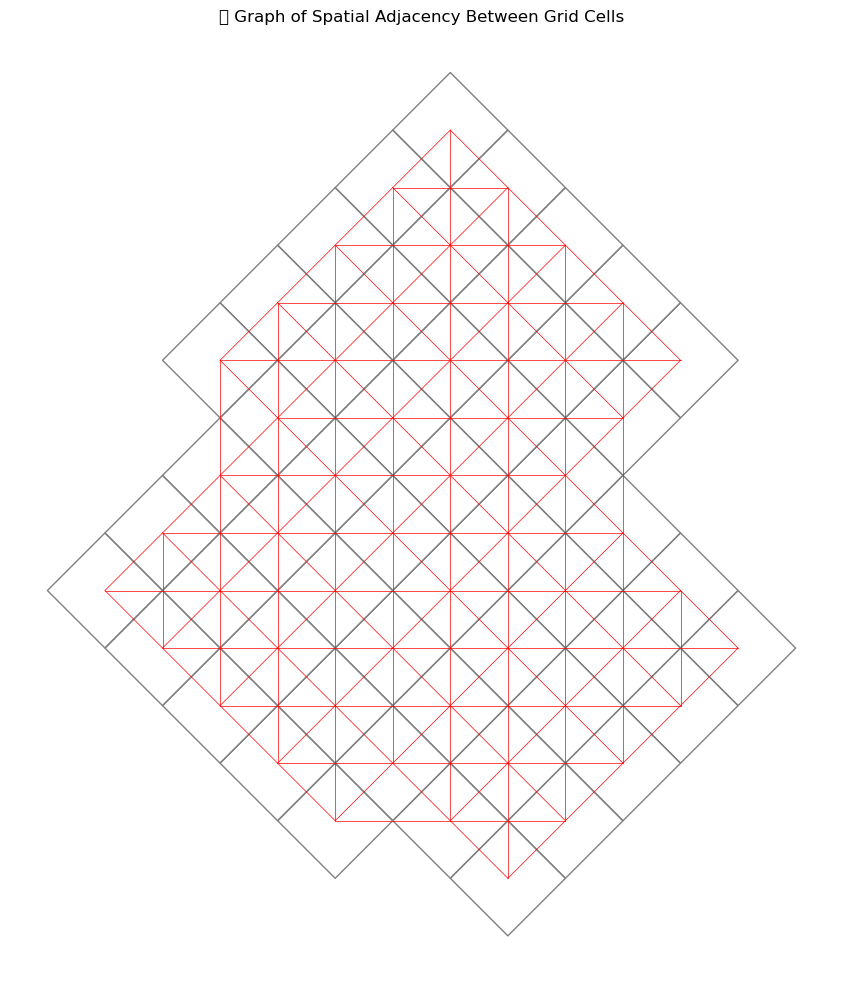

In [74]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# Plot node geometries
node_geoms = [data["geometry"] for _, data in G.nodes(data=True)]
gpd.GeoSeries(node_geoms).plot(ax=ax, edgecolor='gray', facecolor='none')

# Plot edges as lines between centroids
for u, v in G.edges():
    p1 = G.nodes[u]["geometry"].centroid
    p2 = G.nodes[v]["geometry"].centroid
    ax.plot([p1.x, p2.x], [p1.y, p2.y], color='red', linewidth=0.5)

ax.set_title("📡 Graph of Spatial Adjacency Between Grid Cells")
ax.axis("off")
plt.tight_layout()
plt.show()


In [75]:
!pip install torch torch-geometric


In [76]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Define feature and label columns
feature_cols = ["NomNom_count", "CouchCounty_count", "HustleHub_count", "street_length", "num_buildings"]
label_col = "dominant_zone"

# Convert to NumPy arrays
X = zoned_grid[feature_cols].values.astype(np.float32)

# Encode categorical target (dominant_zone) into integers
le = LabelEncoder()
y = le.fit_transform(zoned_grid[label_col].values)


Convert NetworkX graph → PyTorch Geometric Data object
python



In [77]:
from torch_geometric.utils.convert import from_networkx
import torch

# Rebuild graph
G = grid_to_graph(zoned_grid)

# Make sure node labels are consecutive integers
G_nx = nx.convert_node_labels_to_integers(G)

# Convert to PyG format
data = from_networkx(G_nx)

# Assign node features and labels
data.x = torch.tensor(X, dtype=torch.float)
data.y = torch.tensor(y, dtype=torch.long)


In [78]:
Create train/test split mask

SyntaxError: invalid syntax (1082564034.py, line 1)

In [79]:
num_nodes = data.num_nodes
data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.train_mask[:int(0.8 * num_nodes)] = True

data.test_mask = ~data.train_mask


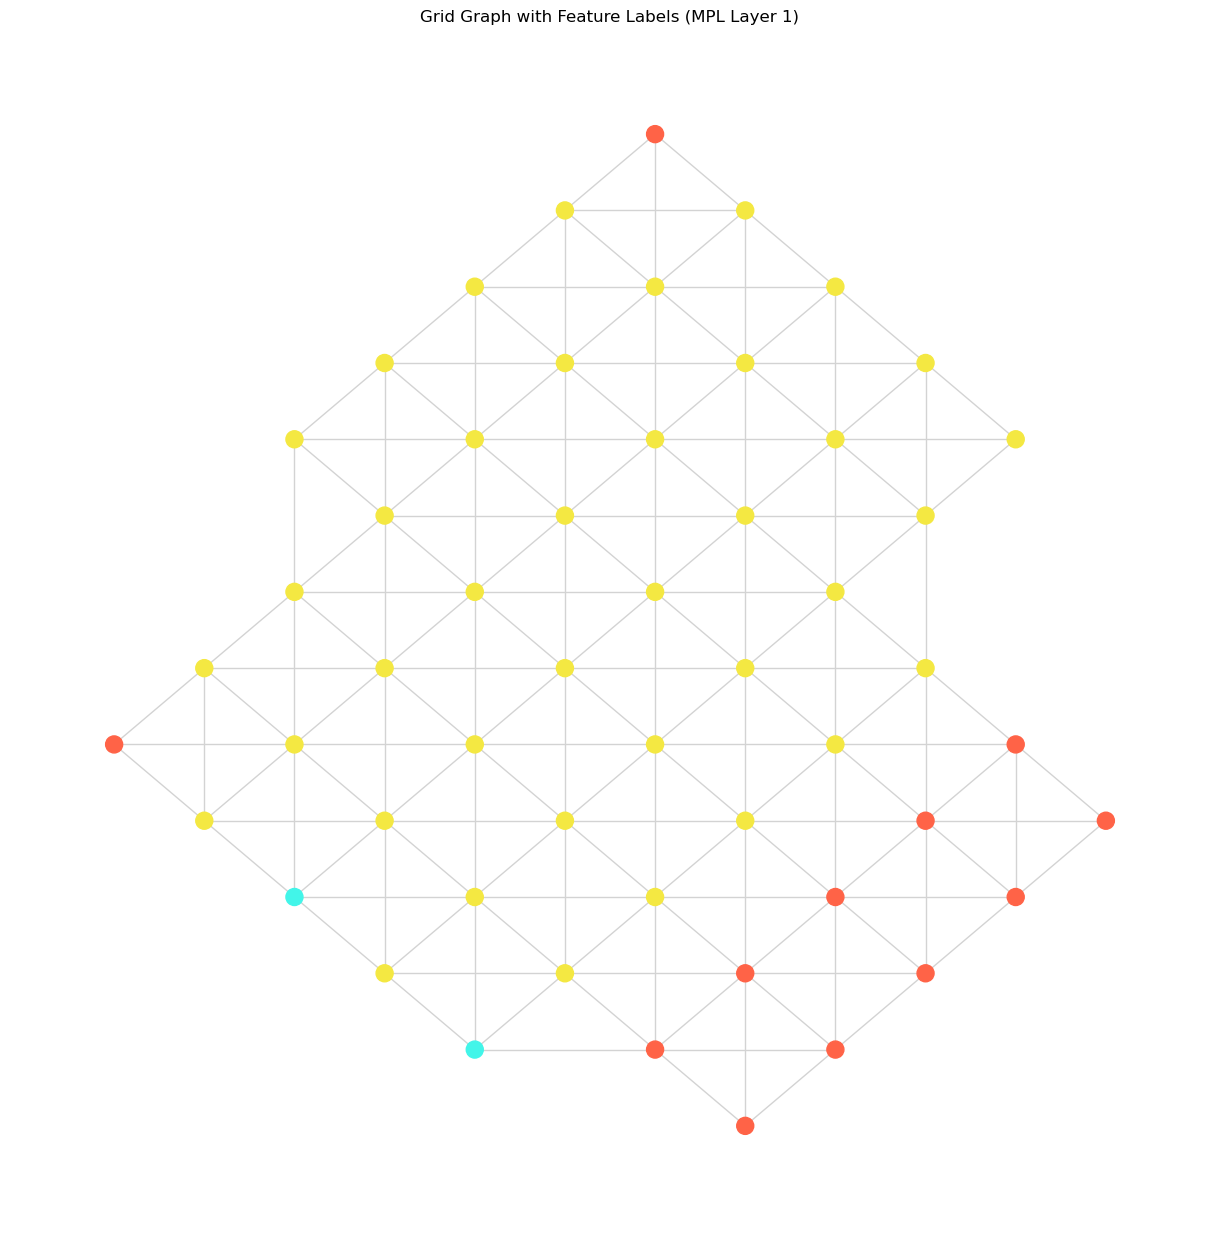

In [80]:
import matplotlib.pyplot as plt
import networkx as nx

# Color by dominant zone
color_map = {
    "NomNom": "#ff6347",
    "CouchCounty": "#f4e842",
    "HustleHub": "#42f5e9"
}

node_colors = [color_map[G.nodes[n]["dominant_zone"]] for n in G.nodes]

# Draw using spring layout or custom layout (centroids?)
pos = {n: (G.nodes[n]["geometry"].centroid.x, G.nodes[n]["geometry"].centroid.y) for n in G.nodes}

plt.figure(figsize=(12, 12))
nx.draw(G, pos, node_color=node_colors, with_labels=False, node_size=150, edge_color='lightgray')
plt.title("Grid Graph with Feature Labels (MPL Layer 1)")
plt.show()


## PREDICT

In [81]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import torch.nn as nn

class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

model = GCN(in_channels=data.x.size(1), hidden_channels=32, out_channels=len(torch.unique(data.y)))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()


In [82]:
for epoch in range(201):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        model.eval()
        pred = out.argmax(dim=1)
        acc = (pred[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Acc: {acc:.4f}")


Epoch 000 | Loss: 201.8795 | Acc: 0.9091
Epoch 020 | Loss: 33.4245 | Acc: 0.0909
Epoch 040 | Loss: 10.4772 | Acc: 0.0909
Epoch 060 | Loss: 3.6153 | Acc: 0.0909
Epoch 080 | Loss: 0.7565 | Acc: 0.0909
Epoch 100 | Loss: 0.4878 | Acc: 0.0909
Epoch 120 | Loss: 0.2588 | Acc: 0.7273
Epoch 140 | Loss: 0.2402 | Acc: 0.9091
Epoch 160 | Loss: 0.2323 | Acc: 0.8182
Epoch 180 | Loss: 0.2260 | Acc: 0.8182
Epoch 200 | Loss: 0.2211 | Acc: 0.8182


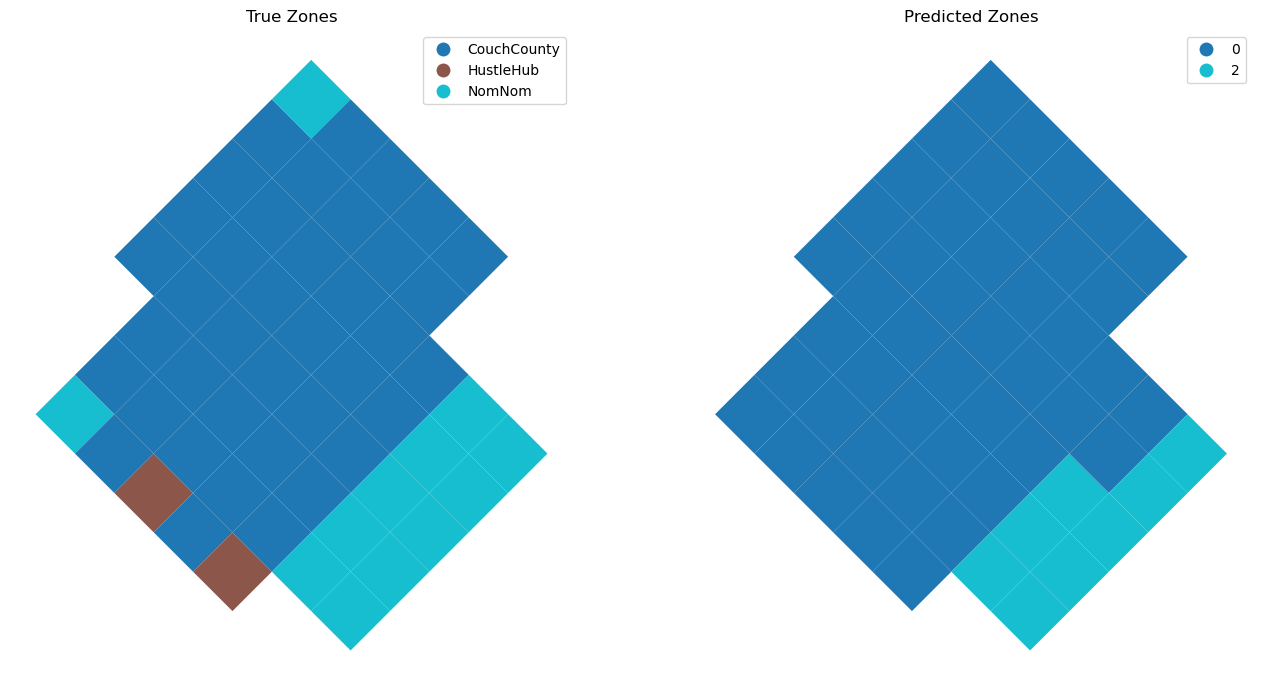

In [83]:
zoned_grid["pred"] = pred.cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Remove 'title=' from plot, and use ax.set_title instead
zoned_grid.plot(column="dominant_zone", ax=axes[0], categorical=True, legend=True)
axes[0].set_title("True Zones")

zoned_grid.plot(column="pred", ax=axes[1], categorical=True, legend=True)
axes[1].set_title("Predicted Zones")

for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.show()



In [84]:
zoned_grid["dominant_zone"].value_counts(normalize=True)


dominant_zone
CouchCounty    0.735849
NomNom         0.226415
HustleHub      0.037736
Name: proportion, dtype: float64

In [85]:
from sklearn.model_selection import train_test_split

labels = zoned_grid["dominant_zone"].astype('category').cat.codes
train_idx, test_idx = train_test_split(
    range(len(labels)),
    stratify=labels,
    test_size=0.2,
    random_state=42
)


In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = data.to(device)

In [87]:
from sklearn.utils.class_weight import compute_class_weight
import torch

class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)


In [88]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Run model on test set
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    preds = out.argmax(dim=1).cpu().numpy()
    true = data.y.cpu().numpy()

# Plot confusion matrix
cm = confusion_matrix(true[test_idx], preds[test_idx])
disp = ConfusionMatrixDisplay(cm, display_labels=your_label_names)
disp.plot(cmap="Blues")


NameError: name 'your_label_names' is not defined

In [89]:
pred_labels = out.argmax(dim=1).cpu().numpy()
true_labels = data.y.cpu().numpy()

from collections import Counter
print("Predicted:", Counter(pred_labels))
print("True:", Counter(true_labels[test_idx]))


Predicted: Counter({np.int64(0): 45, np.int64(2): 8})
True: Counter({np.int64(0): 8, np.int64(2): 3})


In [90]:
class_weights = torch.tensor([1/0.74, 1/0.23, 1/0.04])
loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))


In [91]:
import torch
from sklearn.utils.class_weight import compute_class_weight

# Compute weights inversely proportional to class frequency
labels = zoned_grid["dominant_zone"].astype("category").cat.codes
class_weights = compute_class_weight("balanced", classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Use weighted loss
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)


In [92]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
zoned_grid[feature_cols] = scaler.fit_transform(zoned_grid[feature_cols])


In [93]:
degrees = dict(G.degree())
metadata_grid["degree"] = metadata_grid["cell_id"].map(degrees)



NameError: name 'metadata_grid' is not defined

In [94]:
zoned_grid["cx"] = zoned_grid.geometry.centroid.x
zoned_grid["cy"] = zoned_grid.geometry.centroid.y


In [95]:
from torch_geometric.nn import GATConv
import torch.nn.functional as F

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels*heads, out_channels, heads=1)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

model = GAT(in_channels=data.x.size(1), hidden_channels=16, out_channels=len(le.classes_))


In [96]:
from sklearn.metrics import f1_score, classification_report


In [97]:
# Assuming pred and true_labels are numpy arrays
f1_macro = f1_score(true_labels, pred, average='macro')
f1_micro = f1_score(true_labels, pred, average='micro')

print(f"F1 Macro: {f1_macro:.4f}")
print(f"F1 Micro: {f1_micro:.4f}")
print("\nClassification Report:\n", classification_report(true_labels, pred))


F1 Macro: 0.5762
F1 Micro: 0.8868

Classification Report:
               precision    recall  f1-score   support

           0       0.87      1.00      0.93        39
           1       0.00      0.00      0.00         2
           2       1.00      0.67      0.80        12

    accuracy                           0.89        53
   macro avg       0.62      0.56      0.58        53
weighted avg       0.86      0.89      0.86        53



c:\Users\DELL\anaconda3\envs\barcelona_env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\DELL\anaconda3\envs\barcelona_env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\DELL\anaconda3\envs\barcelona_env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

In [98]:
import geopandas as gpd
import pandas as pd
import networkx as nx
from shapely import prepared
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch.nn import functional as F
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
import numpy as np


In [99]:
grid = gpd.read_file("data/expanded_grid.geojson")
pois = gpd.read_file("data/pois.geojson")
streets = gpd.read_file("data/streets.geojson")
buildings = gpd.read_file("data/buildings.geojson")

grid = grid[grid.is_valid]
grid["cell_id"] = range(len(grid))
grid = grid.set_index("cell_id")


DataSourceError: data/expanded_grid.geojson: No such file or directory

In [100]:
import torch

# Your final PyG graph object with features and labels
# `data` includes: data.x, data.y, data.train_mask, data.test_mask, edges

# Save to file
torch.save(data, "urban_zoning_graph_data.pt")


In [101]:
import joblib

# Save label encoder to decode prediction outputs later
joblib.dump(le, "label_encoder.pkl")

# Load later
# le = joblib.load("label_encoder.pkl")


['label_encoder.pkl']

In [115]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class GraphSAGEClassifier(nn.Module):
    def __init__(self, in_feats, hidden_feats=128, out_feats=3):
        super().__init__()
        self.conv1 = SAGEConv(in_feats, 128)
        self.conv2 = SAGEConv(128, out_feats)

        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, out_feats)  # for classification

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [139]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class GraphSAGE2Layer(nn.Module):
    def __init__(self, in_feats, hidden_feats=128, out_feats=3):
        super().__init__()
        self.conv1 = SAGEConv(in_feats, hidden_feats)
        self.conv2 = SAGEConv(hidden_feats, out_feats)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        x = F.dropout(x, p=0.3, training=self.training)
        return x


In [140]:
from sklearn.metrics import f1_score
import torch.optim as optim

def train(model, data, epochs=100, lr=0.01):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            acc = evaluate(model, data)
            print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Test Acc: {acc:.4f}")

def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        logits = model(data.x, data.edge_index)
        preds = logits[data.test_mask].argmax(dim=1)
        true = data.y[data.test_mask]
        acc = (preds == true).sum().item() / len(true)
        f1 = f1_score(true.cpu(), preds.cpu(), average='micro')
        return f1


In [149]:
# Initialize
in_feats = data.num_node_features
out_feats = len(le.classes_)

model = GraphSAGE2Layer(in_feats, out_feats=out_feats)

train(model, data, epochs=100, lr=0.01)

# Save model if needed
torch.save(model.state_dict(), "gnn_zoning_model.pt")


Epoch 000 | Loss: 1.1558 | Test Acc: 0.7273
Epoch 010 | Loss: 0.2619 | Test Acc: 1.0000
Epoch 020 | Loss: 0.1914 | Test Acc: 1.0000
Epoch 030 | Loss: 0.1349 | Test Acc: 1.0000
Epoch 040 | Loss: 0.1162 | Test Acc: 1.0000
Epoch 050 | Loss: 0.1133 | Test Acc: 1.0000
Epoch 060 | Loss: 0.1765 | Test Acc: 1.0000
Epoch 070 | Loss: 0.0787 | Test Acc: 1.0000
Epoch 080 | Loss: 0.1778 | Test Acc: 1.0000
Epoch 090 | Loss: 0.0888 | Test Acc: 1.0000


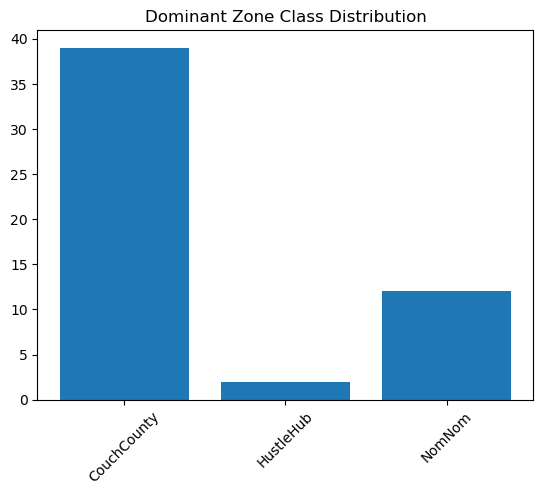

In [143]:
import numpy as np
import matplotlib.pyplot as plt
unique, counts = np.unique(y, return_counts=True)
plt.bar(le.inverse_transform(unique), counts)
plt.title("Dominant Zone Class Distribution")
plt.xticks(rotation=45)
plt.show()


In [ ]:
print("Train nodes:", data.train_mask.sum().item())
print("Test nodes:", data.test_mask.sum().item())


Train nodes: 42
Test nodes: 11


In [144]:
import pandas as pd
pd.Series(le.inverse_transform(data.y.cpu().numpy())).value_counts()


CouchCounty    39
NomNom         12
HustleHub       2
Name: count, dtype: int64

In [145]:
print(data.x.shape)  # Should be (num_nodes, num_features)
print(data.y.shape)  # Should be (num_nodes,)


torch.Size([53, 5])
torch.Size([53])


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data.x = torch.tensor(scaler.fit_transform(data.x), dtype=torch.float)


In [147]:
from sklearn.model_selection import train_test_split

indices = np.arange(data.num_nodes)
labels = data.y.cpu().numpy()

train_idx, test_idx = train_test_split(
    indices, test_size=0.2, random_state=42, stratify=labels)

data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[train_idx] = True
data.test_mask[test_idx] = True

print("✅ Stratified split applied")


✅ Stratified split applied


In [148]:
from sklearn.metrics import f1_score

def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        logits = model(data.x, data.edge_index)
        preds = logits[data.test_mask].argmax(dim=1)
        true = data.y[data.test_mask]
        return f1_score(true.cpu(), preds.cpu(), average="micro")


In [150]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion(model, data, label_encoder):
    model.eval()
    with torch.no_grad():
        logits = model(data.x, data.edge_index)
        preds = logits[data.test_mask].argmax(dim=1).cpu().numpy()
        true = data.y[data.test_mask].cpu().numpy()
        cm = confusion_matrix(true, preds, labels=np.arange(len(label_encoder.classes_)))
        disp = ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_)
        disp.plot(cmap="Blues", xticks_rotation=45)


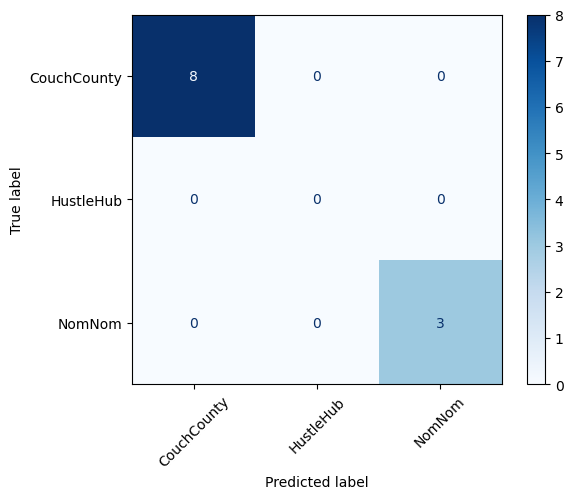

In [151]:
plot_confusion(model, data, le)


In [152]:
torch.save(model.state_dict(), "gnn_zoning_model.pt")

import joblib
joblib.dump(le, "label_encoder.pkl")


['label_encoder.pkl']

In [153]:
train_idx, val_idx = train_test_split(train_idx, test_size=0.2, stratify=data.y[train_idx])

data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.val_mask[val_idx] = True


In [154]:
model.eval()
with torch.no_grad():
    logits = model(data.x, data.edge_index)
    preds = logits.argmax(dim=1).cpu().numpy()

# Convert back to zone names
predicted_labels = le.inverse_transform(preds)


In [155]:
zoned_grid["predicted_zone"] = predicted_labels
zoned_grid["predicted_color"] = zoned_grid["predicted_zone"].map(lambda z: CATEGORY_INFO[z]["color"])


In [156]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_predicted_zones(gdf, category_info, boundary=None, title="Predicted Zone per Grid Cell"):
    fig, ax = plt.subplots(figsize=(12, 12))

    if boundary is not None:
        boundary.to_crs(gdf.crs).plot(ax=ax, facecolor="white", edgecolor="black", linewidth=1)

    gdf.plot(ax=ax, facecolor=gdf["predicted_color"], edgecolor="gray", linewidth=0.2)

    legend_patches = [
        mpatches.Patch(color=info["color"], label=info["label"])
        for info in category_info.values()
    ]
    ax.legend(handles=legend_patches, loc="upper right", title="Predicted Zone", frameon=True)
    ax.set_title(title, fontsize=15)
    ax.axis("off")
    plt.tight_layout()
    plt.show()


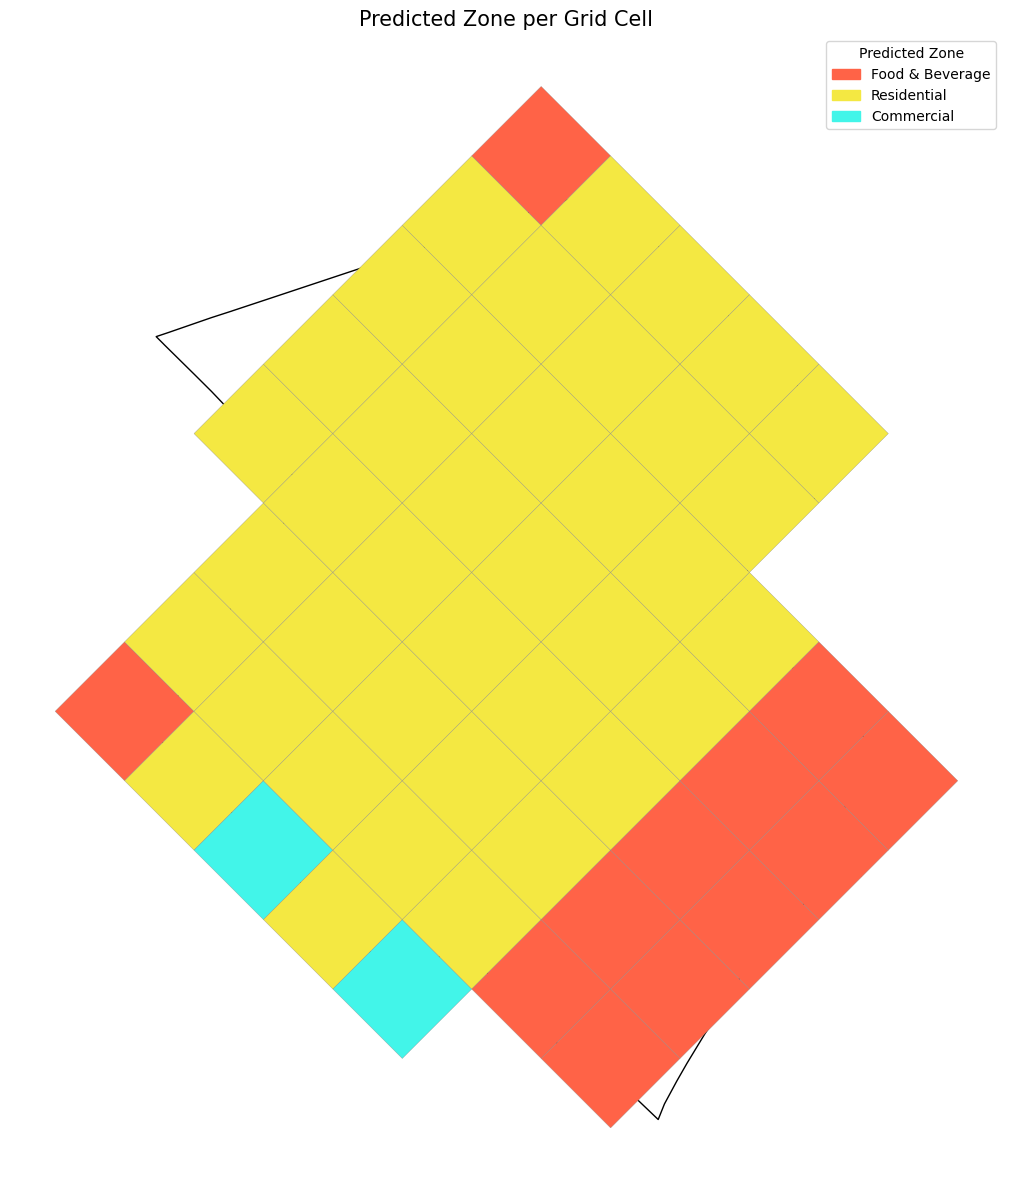

In [157]:
plot_predicted_zones(zoned_grid, CATEGORY_INFO, boundary=boundary)


In [158]:
# On train set
train_preds = model(data.x, data.edge_index)[data.train_mask].argmax(dim=1)
train_true = data.y[data.train_mask]
train_acc = (train_preds == train_true).sum().item() / train_true.size(0)

# On test set
test_preds = model(data.x, data.edge_index)[data.test_mask].argmax(dim=1)
test_true = data.y[data.test_mask]
test_acc = (test_preds == test_true).sum().item() / test_true.size(0)

print(f"Train Acc: {train_acc:.4f}")
print(f"Test Acc : {test_acc:.4f}")


Train Acc: 1.0000
Test Acc : 1.0000


In [159]:
place_name = "Poblenou, Barcelona, Spain"
buffer_meters = 1000  # expands around Poblenou

boundary = ox.geocode_to_gdf(place_name).to_crs(epsg=3857)
expanded_boundary = boundary.buffer(buffer_meters)


In [161]:
import osmnx as ox

# Create expanded Poblenou boundary
place_name = "Poblenou, Barcelona, Spain"
buffer_m = 1000
original_boundary = ox.geocode_to_gdf(place_name).to_crs(epsg=3857)
expanded_boundary = gpd.GeoDataFrame(geometry=original_boundary.buffer(buffer_m), crs=original_boundary.crs)

# Use class with expanded polygon
generator = RotatedGridGenerator(custom_boundary=expanded_boundary, grid_size=250, rotation_angle=-45)
grid, boundary = generator.generate_rotated_unclipped_grid()


TypeError: RotatedGridGenerator.__init__() got an unexpected keyword argument 'custom_boundary'

In [169]:
G = ox.graph_from_polygon(boundary.geometry.unary_union, network_type="walk")

visualizer = OSMLandUseVisualizer(place_name=None, graph=G)  # place_name not needed
visualizer.dataframes = {}  # clear default

# Download POIs manually for the expanded boundary
for label, tag in visualizer.tags.items():
    gdf = ox.features.features_from_polygon(boundary.geometry.unary_union, tags=tag)
    visualizer.dataframes[label] = gdf
    print(f"{label} raw count: {len(gdf)}")

visualizer.simplify_geometry()

# Store simplified POIs
poi_dfs = visualizer.dataframes


C:\Users\DELL\AppData\Local\Temp\ipykernel_37036\1530344090.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  G = ox.graph_from_polygon(boundary.geometry.unary_union, network_type="walk")


RuntimeError: Unable to determine UTM CRS

In [ ]:
builder = CityGridMetadataBuilder(grid, year=2025)
builder.prepare_pois(poi_dfs)

# Define your zone-color-label dictionary
CATEGORY_INFO = {
    "NomNom": {"label": "Food & Drink", "color": "limegreen"},
    "CouchCounty": {"label": "Residential", "color": "gold"},
    "HustleHub": {"label": "Commercial", "color": "tomato"},
}

builder.classify_dominant_zone(poi_dfs, CATEGORY_INFO)


In [ ]:
# Streets
streets_gdf = ox.graph_to_gdfs(G, nodes=False, edges=True)
builder.add_street_length(streets_gdf)

# Buildings
building_tags = {"building": True}
buildings_gdf = ox.features.features_from_polygon(boundary.geometry.unary_union, tags=building_tags)
builder.add_building_count(buildings_gdf)


In [ ]:
zoned_grid = builder.get_grid_with_metadata()
